In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize(mean=(0.5,), std=(0.5,))  
])

train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   download=True,
                                   transform=transform)

test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  download=True,
                                  transform=transform)

class_names = train_data.classes

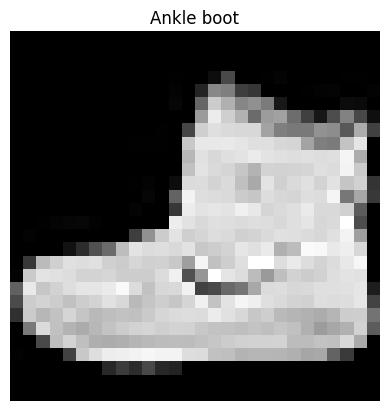

In [3]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()

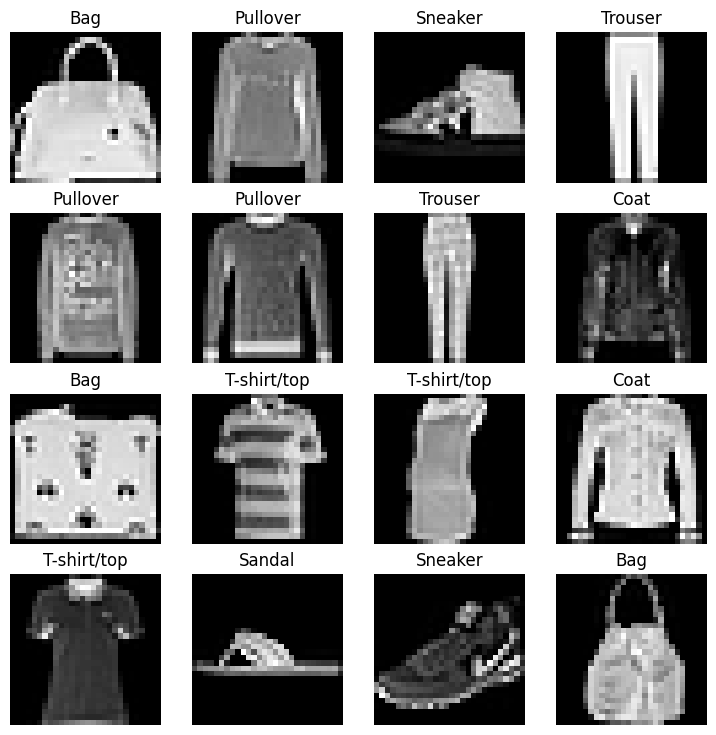

In [4]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, (rows*cols)+1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()

    img, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

In [5]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)


test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

print(f'{len(train_dataloader)}, {len(test_dataloader)}')

1875, 313


In [6]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28]) | label: 3


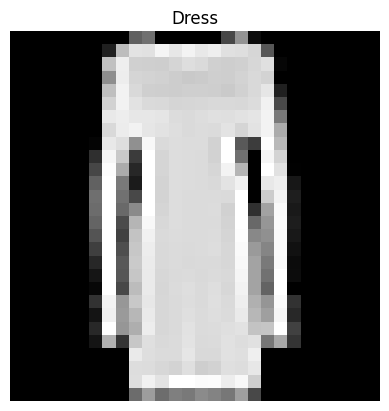

In [7]:
random_index = torch.randint(0, len(train_features_batch), size=[1]).item()

img, label = train_features_batch[random_index], train_labels_batch[random_index]

plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
print(f'Image size: {img.shape} | label: {label}')
plt.show()

In [8]:
flatten = nn.Flatten()
X = train_features_batch
X.shape, flatten(X).shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 784]))

In [9]:
import torch
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape) 
        )

    def forward(self, x):
        return self.layer_stack(x)


In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [11]:
import requests
from pathlib import Path

url = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'

if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download ....')

else:
    print('Downloading helper_functions.py')
    requests.get(url)
    with open('helper_functions.py', 'bw') as f:
        f.write(requests.content)

helper_functions.py already exists, skipping download ....


In [12]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {'model_name': model.__class__.__name__,
            'model_ loss': loss.item(),
            'model_acc': acc}

In [13]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
    
    train_loss, train_acc = 0, 0

    model.train()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%')

In [14]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
    
    test_loss, test_acc = 0, 0

    model.eval()

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_loss += loss_fn(test_pred, y)
        test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f'Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%\n')

In [15]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n---------')

    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_0,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.9672 | Train acc: 62.71%
Test loss: 0.5706 | Test acc: 80.89%

Epoch: 1
---------
Train loss: 0.8173 | Train acc: 69.26%
Test loss: 0.5823 | Test acc: 80.59%

Epoch: 2
---------
Train loss: 0.7800 | Train acc: 71.06%
Test loss: 0.5792 | Test acc: 79.93%



In [16]:
model_0_result = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model_0_result

{'model_name': 'FashionMNISTModelV0',
 'model_ loss': 0.5792133808135986,
 'model_acc': 79.93210862619809}